In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams['figure.figsize'] = (12, 8)

# https://newonlinecourses.science.psu.edu/stat505/node/49/
# http://kvfrans.com/simple-algoritms-for-solving-cartpole/
# https://newonlinecourses.science.psu.edu/stat505/node/54/
# https://github.com/openai/gym/wiki/CartPole-v0
# https://towardsdatascience.com/dive-into-pca-principal-component-analysis-with-python-43ded13ead21

In [2]:
import gym
env = gym.make('CartPole-v0')

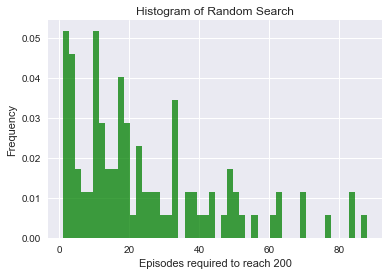

average number of steps to converge 24.71


In [3]:
experiance = []

def run_episode(env, parameters):
    observation = env.reset()
    totalreward = 0
    for _ in range(200):
        action = 0 if np.matmul(parameters, observation) < 0 else 1
        observation, reward, done, info = env.step(action)
        #observation += np.random.rand(4) * 2 - 1
        experiance.append(observation)
        totalreward += reward
        if done:
            break
    return totalreward

def train():
    env = gym.make('CartPole-v0')
    
    counter = 0
    bestparams = None
    bestreward = 0
    for _ in range(2000):
        counter += 1
        parameters = np.random.rand(4) * 2 - 1
        
        reward = 0
        # run few times to make sure it is good parameters
        for _ in range(5):  
            run = run_episode(env, parameters)
            reward += run
        reward = reward / 5
        
        if reward > bestreward:
            bestreward = reward
            bestparams = parameters
            # stop if we reached maximum
            if reward == 200:
                #print('super win')
                break

    return counter

# create graphs
results = []
for _ in range(100):
    #print(_)
    results.append(train())

plt.hist(results,50,normed=1, facecolor='g', alpha=0.75)
plt.xlabel('Episodes required to reach 200')
plt.ylabel('Frequency')
plt.title('Histogram of Random Search')
plt.show()

print('average number of steps to converge', np.mean(results))

In [4]:
experiance = np.array(experiance)
experiance.shape

(622211, 4)

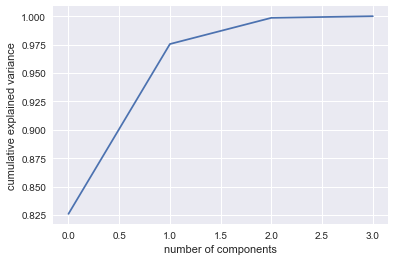

In [5]:
pca = PCA()
pca.fit(experiance)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [6]:
pca = PCA(4).fit(experiance)
components = pca.transform(experiance)
projected = pca.inverse_transform(components)

print(components[2])
print(projected[2])
print(experiance[2])

np.sum(pca.explained_variance_ratio_)

[-0.29126831 -0.02925424 -0.01820903 -0.04297033]
[ 0.01033504  0.16383844  0.02944699 -0.24988211]
[ 0.01033504  0.16383844  0.02944699 -0.24988211]


0.9999999999999999

PCA

In [10]:
def run_episode(env, parameters, pca):
    observation = env.reset()
    totalreward = 0
    for _ in range(200):
        pca_observation = pca.transform([observation])[0]
        action = 0 if np.matmul(parameters, pca_observation) < 0 else 1
        #pca_observation = np.append(pca_observation, 1)
        observation, reward, done, info = env.step(action)
        totalreward += reward
        if done:
            break
    return totalreward

def train(pca, pca_size=4):
    env = gym.make('CartPole-v0')
    
    counter = 0
    bestparams = None
    bestreward = 0
    for _ in range(700):
        counter += 1
        parameters = np.random.rand(pca_size) * 2 - 1
        run = run_episode(env, parameters, pca)
        
        # skip if we lost a game
        if run < 200:
            continue
        
        reward = 0
        for _ in range(5):  
            run = run_episode(env, parameters, pca)
            reward += run
        reward = reward / 5
        
        if reward > bestreward:
            bestreward = reward
            bestparams = parameters
            if reward == 200:
                print('super win')
                break

    return counter

# create graphs
pca_performance = []
pca_performance_data = []
for pca_size in [1,2,3,4]:
    pca = PCA(pca_size)
    pca.fit(experiance)

    results = []
    for _ in range(100):
        #print(_)
        results.append(train(pca, pca_size))

    plt.hist(results,50,normed=1, facecolor='g', alpha=0.75)
    plt.xlabel('Episodes required to reach 200')
    plt.ylabel('Frequency')
    plt.title('Histogram of Random Search')
    plt.show()
    print('average number of steps to converge', np.mean(results))

    pca_performance.append(np.mean(results))
    pca_performance_data.append(results)

0
1
2
3
4
5


KeyboardInterrupt: 

In [ ]:
for pca_size in [1,2,3,4]:
    index = pca_size-1

    results = pca_performance_data[index]
    plt.hist(results,50,normed=1, facecolor='g', alpha=0.75)
    plt.xlabel('Episodes required to reach 200. PCA size = ' + str(pca_size))
    plt.ylabel('Frequency')
    plt.title('Histogram of Random Search')
    plt.show()

In [ ]:
for pca_size in [1,2,3,4]:
    index = pca_size-1
    print(pca_size, pca_performance[index])

In [ ]:
# matplotlib stacked bar chart
# https://stackoverflow.com/questions/44309507/stacked-bar-plot-using-matplotlib
# https://stats.stackexchange.com/questions/253718/correlation-between-an-original-variable-and-a-principal-component
pca = PCA(4).fit(experiance)

components_ = np.abs(pca.components_.T)
pc = ['pc1','pc2','pc3','pc4']
ind = [x for x, _ in enumerate(pc)]

pc1 = components_[0]
pc2 = components_[1]
pc3 = components_[2]
pc4 = components_[3]

total = pc1 + pc2 + pc3 + pc4
proportion_pc1 = np.true_divide(pc1, total) * 100
proportion_pc2 = np.true_divide(pc2, total) * 100
proportion_pc3 = np.true_divide(pc3, total) * 100
proportion_pc4 = np.true_divide(pc4, total) * 100

plt.bar(ind, proportion_pc1, label='Cart Position', width=0.5, bottom=proportion_pc2+proportion_pc3+proportion_pc4)
plt.bar(ind, proportion_pc2, label='Cart Velocity', width=0.5, bottom=proportion_pc3+proportion_pc4)
plt.bar(ind, proportion_pc3, label='Pole Angle', width=0.5, bottom=proportion_pc4)
plt.bar(ind, proportion_pc4, label='Pole Velocity At Tip', width=0.5)

plt.xticks(ind, pc)
plt.ylabel("States")
plt.xlabel("Principal components")
plt.legend()
plt.title("Correlation between an original variable and Principal Component")
plt.ylim=1.0

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

In [ ]:
pca.components_